In [1]:
import array
import os
import os.path as op
import multiprocessing
print(multiprocessing.cpu_count())
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tqdm import tqdm

import timescales as fw
import timescales.data as fwd
import timescales.simulation_plasticity as fwsp

128


## Generate contexts from van Hateren dataset

In [2]:
def extract_patches(img, patch_h, patch_w, sigma, n_steps, rng):
    walk_h, walk_w = fwd.random_walk(n_steps, sigma=sigma, rng=rng)
    h0, w0 = img.shape[0] // 2, img.shape[1] // 2
    walk_h = walk_h + h0
    walk_w = walk_w + w0
    patches = np.array([img[h:h+patch_h, w:w+patch_w] for h, w in zip(walk_h, walk_w)])
    return patches, np.stack((walk_h, walk_w), 1)

def load_image(
    data_dir: str = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc", 
    filename = "", 
    crop_size: int = 512, 
    rng  = None,
    )  :
    """Loads randomly cropped img from van hateren dataset."""

    if rng is None:
        rng = np.random.default_rng()

    with open(op.join(data_dir, filename), 'rb') as handle:
        s = handle.read()
        arr = array.array('H', s)
        arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(1024, 1536)
    H, W = img.shape

    rand_h = rng.integers(0, H-crop_size, 1)[0]
    rand_w = rng.integers(0, W-crop_size, 1)[0]
    img = img[rand_h:rand_h + crop_size, rand_w:rand_w + crop_size]
    return img

def image_patches(i, seed):
    rng = np.random.default_rng(seed)
    img = load_image(filename=files[i], rng=rng)
    patches, coords = extract_patches(img, patch_h, patch_w, sigma, n_steps, rng)
    patches = np.squeeze(patches)
    cov = np.cov(patches.T)
    return cov

def plot_two_images(i, j, all_covs, files):
    fig, ax = plt.subplots(2, 2, sharex='row', sharey='row')
    ax = ax.ravel()
    ax[0].imshow(load_image(filename=files[i], rng=np.random.default_rng(i)), cmap='gray', vmin=200, vmax=2000)
    ax[1].imshow(load_image(filename=files[j], rng=np.random.default_rng(j)), cmap='gray', vmin=200, vmax=2000)
    MAX = 1
    ax[2].imshow(fw.normalize_cov(all_covs[i]), cmap='icefire', vmax=MAX, vmin=-MAX)
    ax[3].imshow(fw.normalize_cov(all_covs[j]), cmap='icefire', vmax=MAX, vmin=-MAX)

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    sns.despine()
    # remove whitespace between columns
    fig.subplots_adjust(wspace=-.5, hspace=0)
    fig.tight_layout()

In [5]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed_data = 42069

patch_h, patch_w = 16, 1
N = patch_h * patch_w

sigma = .6
n_steps = 20_000

with multiprocessing.Pool() as pool:
    covs = pool.starmap(image_patches, ((i, seed_data) for i in range(len(files))))

print(len(covs))

4167


num covs w less than 20.00 thresh: 527


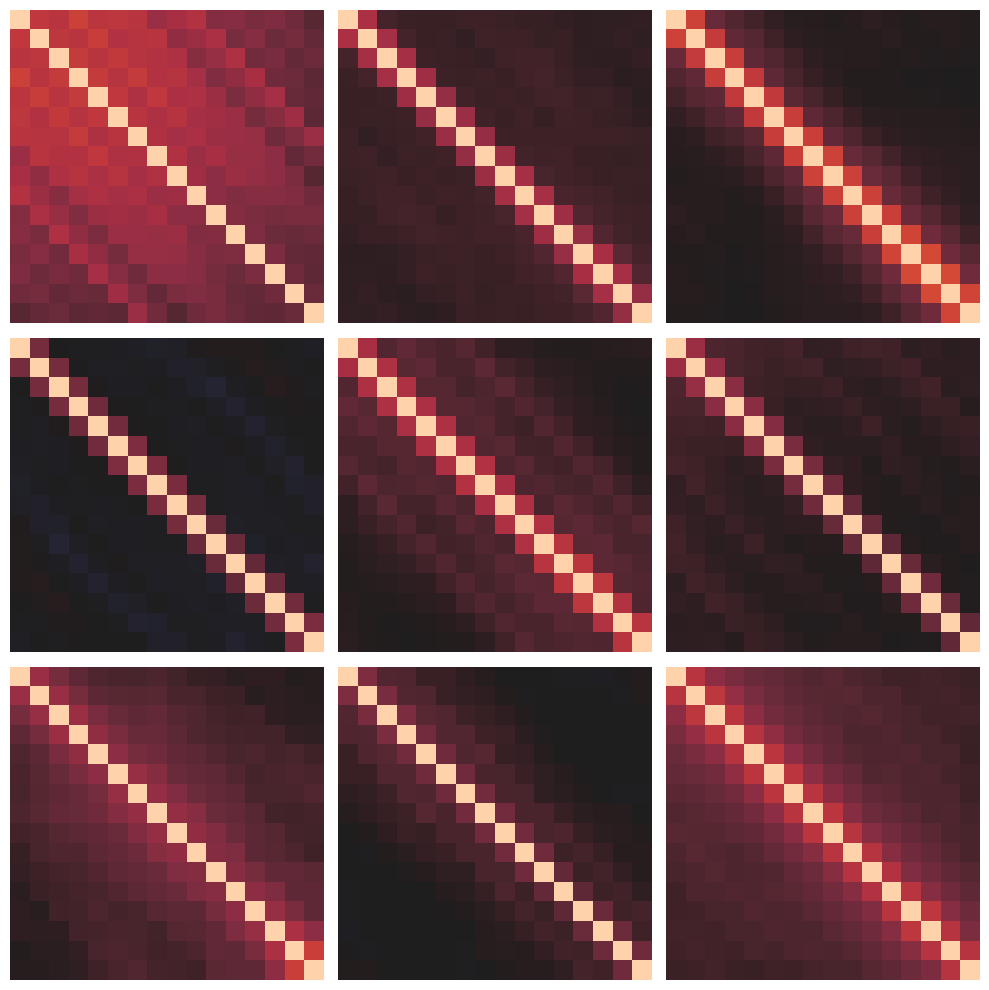

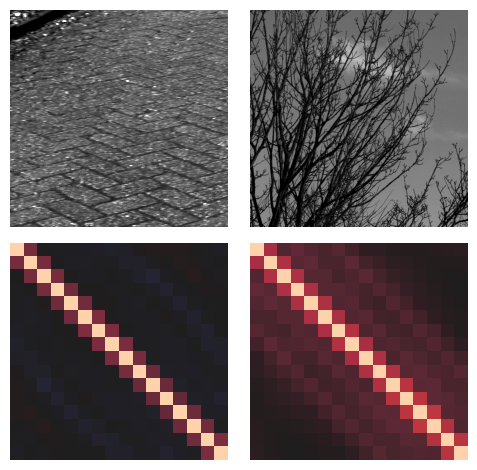

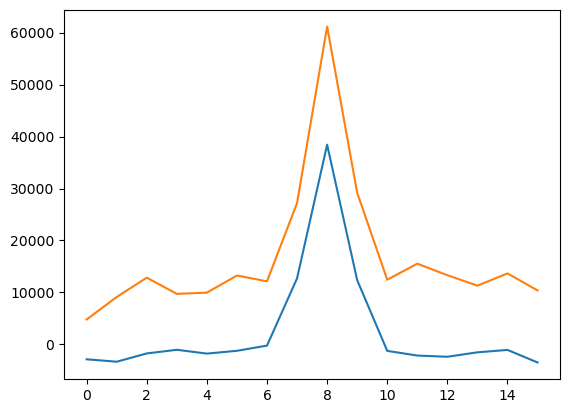

In [6]:
# toss out ill-conditioned contexts
cond_thresh = 20
cond_nums = np.array([np.linalg.cond(cov) for cov in covs])
print(f'num covs w less than {cond_thresh:.2f} thresh: {np.sum(cond_nums<cond_thresh):d}')

all_covs = np.stack(covs, 0)
cond_filt_idx = np.where(cond_nums<cond_thresh)[0]
filtered_covs = all_covs[cond_filt_idx]

# display examples
fwsp.plot_corrs(filtered_covs)
to_plot = (3, 4)  # chosen by eye
plot_two_images(cond_filt_idx[to_plot[0]], cond_filt_idx[to_plot[1]], all_covs, files)

# plot slice of covariance matrices
fig, ax = plt.subplots(1, 1)
ax.plot(all_covs[cond_filt_idx[to_plot[0]]][N//2])
ax.plot(all_covs[cond_filt_idx[to_plot[1]]][N//2])

## Train/test the model

In [7]:
# bound spectral radii of each context
spectral_radius = 10
norm_filtered = np.array([C/np.linalg.norm(C, 2) for C in filtered_covs]) * spectral_radius

N, K =  patch_h, patch_h
n_samples = 100_000
eta_w = 1E1
seed = 18

from sklearn.model_selection import train_test_split
def train_test_experiment(Cxx_list, N, K, eta_w, n_samples, seed, test_size=0.2, verbose=True):
    Cxx_train, Cxx_test = train_test_split(Cxx_list, test_size=test_size, random_state=seed)
    results_train = fwsp.context_adaptation_experiment(Cxx_train, N, K, eta_w, n_samples, seed=seed, verbose=verbose)
    W0 = results_train['W']
    g0 = np.mean(results_train['g'][-100:], axis=0)

    # test set, set n_samples to 0 to automatically set n_samples to len(Cxx_test)
    T_test = n_samples
    results_test =  fwsp.context_adaptation_experiment(Cxx_test, N, K, 0., n_samples=0, W0=W0, seed=seed, verbose=verbose)
    results_test_no_gain = fwsp.context_adaptation_experiment(Cxx_test, N, K, 0., n_samples=0, g0=g0, W0=W0, seed=seed, verbose=verbose) 
    # results_test_rand_weights = fwsp.context_adaptation_experiment(Cxx_test, N, K, eta_w, n_samples=T_test, g0=g0, W0=W0, seed=seed, verbose=verbose) 

    results = {
        'train': results_train,
        'test': results_test, 
        'test_no_gain': results_test_no_gain,
        # 'test_rand_weights': results_test_rand_weights,
    }

    return results

# synthesize control contexts
norm_filtered_ctrl = fwsp.get_cov_controls(norm_filtered, seed)

# run experiment once on real and control contexts
with multiprocessing.Pool() as pool:
    results = pool.starmap(
        train_test_experiment,
        [(Cxx_list, N, K, eta_w, n_samples, 42069) for Cxx_list in [norm_filtered, norm_filtered_ctrl]]
        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 11539.56it/s]


In [ ]:
# run experiment once on real and control contexts
with multiprocessing.Pool() as pool:
    results_repeated = pool.starmap(
        train_test_experiment,
        [(norm_filtered, N, K, eta_w, n_samples, seed, 0.2, False) for seed in range(100)]
        )

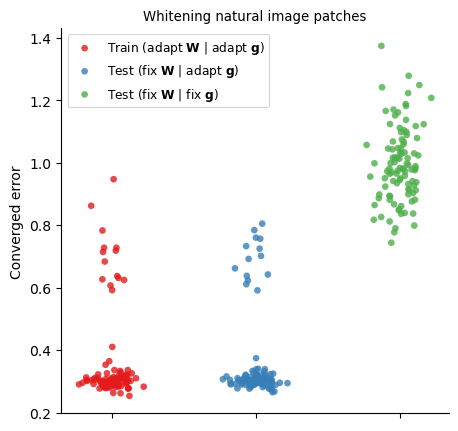

In [ ]:
import collections
import pandas as pd
def plot_repeated_results(results_repeated):
    # plot avg of last 1000 samples
    dict_plot = collections.defaultdict(list)
    keys = ['train', 'test', 'test_no_gain']
    for key in keys:
        dict_plot[key].extend([np.mean(results_repeated[i][key]['error'][-100:]) for i in range(len(results_repeated))])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    colors = sns.color_palette('Set1', 4)
    jitter = np.random.normal(0, 0.1, len(dict_plot[key]))
    labels = [
    r'Train (adapt ${\bf W}$ | adapt ${\bf g}$)',
    r'Test (fix ${\bf W}$ | adapt ${\bf g}$)',
    # r'Test (adapt ${\bf W}$ | fix ${\bf g}$)',
    r'Test (fix ${\bf W}$ | fix ${\bf g}$)',
    ]
    with sns.plotting_context('paper'):
        for i, key in enumerate(keys):
            x = np.array([i]*len(dict_plot[key])) + jitter
            ax.scatter(x, dict_plot[key], color=colors[i], label=labels[i], alpha=0.8, edgecolors='none')
        
        ax.set(yscale='linear', xticks=range(len(labels)), ylabel='Converged error', xticklabels=[], title='Whitening natural image patches')
        ax.legend()
        sns.despine()

plot_repeated_results(results_repeated)

In [ ]:
def plot_experiment_diagnostic(results):
    
    W0, W = results['train']['W0'], results['train']['W']
    W_hat = fwsp.optimal_alignment(fw.normalize_frame(W), sp.fftpack.dct(np.eye(W.shape[0])), align_type='permutation')
    fig, ax = plt.subplots(2, 3, figsize=(12, 6), dpi=300)
    ax = ax.ravel() 

    MAX = np.max(np.abs(fw.normalize_frame(W)))
    MAX = 1
    cmap = 'icefire'
    sns.heatmap(fw.normalize_frame(W0), square=True, cbar=True, cmap=cmap, ax=ax[0], vmin=-MAX, vmax=MAX)
    sns.heatmap(fw.normalize_frame(W_hat), square=True, cbar=True, cmap=cmap, ax=ax[1], vmin=-MAX, vmax=MAX)
    sns.heatmap(np.corrcoef(W_hat.T), square=True, cbar=True, cmap=cmap, ax=ax[2], vmin=-1, vmax=1)

    # smooth the error with moving average
    window_size = 1000
    T = 100_000
    # ax[3].hlines(np.mean(results['test_no_gain']['error']), 0, T, label=r'Test (fixed ${\bf W}$ & ${\bf g}$)', color='C0')
    # ax[3].hlines(np.mean(results['test_rand_weights']['error']), 0, T, label=r'Test (fixed ${\bf g}$)', color='C3')
    ax[3].plot(fwsp.smooth(results['test_no_gain']['error'], window_size)[:T], label=r'Test (fix ${\bf W}$ | fix ${\bf g}$)', color='C0')
    ax[3].plot(fwsp.smooth(results['test_rand_weights']['error'], window_size)[:T], label=r'Test (adapt ${\bf W}$ | fix ${\bf g}$)', color='C3')
    ax[3].plot(fwsp.smooth(results['test']['error'], window_size)[:T], label=r'Test (fix ${\bf W}$ | adapt ${\bf g}$)', color='C1')
    # ax[3].hlines(np.mean(results['test']['error']), 0, T, label=r'Test (Fixed ${\bf W}$)', color='C1')
    ax[3].plot(fwsp.smooth(results['train']['error'], window_size)[:T], label=r'Train (adapt ${\bf W}$ | adapt ${\bf g}$)', color='C2')

    ax[4].plot(fwsp.smooth(results['train']['dW_norm'], window_size))
    ax[5].plot(fwsp.smooth(results['train']['error_dct_perm'], window_size))

    ax[3].legend(loc='center right', title='Error', fontsize=7)

    ax[0].set(title=r"${\bf W}$ init");
    ax[1].set(title=r"${\bf W}$ final");
    ax[2].set(title=r"${\bf W}^\top{\bf W}$");
    ax[3].set(yscale='log', xscale='linear', title='Error', ylabel=r"$\Vert {\bf C}_{yy}-{\bf I}_N \Vert_{Op}$", xlabel='Step');
    ax[4].set(yscale='linear', xscale='linear', title='dW', ylabel=r"$\Vert \frac{\partial \mathcal{L}}{\partial {\bf W}}\Vert_F$", xlabel='Step');
    ax[5].set(yscale='linear', xscale='linear', title='DCT Error', ylabel=r"$\Vert {\bf W}_{DCT} - {\bf W}_T {\bf P} \Vert_F$", xlabel='Step');
    fig.tight_layout()
    sns.despine()

# fwsp.plot_corrs(norm_filtered_ctrl, 2, 2)
plot_experiment_diagnostic(results[0])
plot_experiment_diagnostic(results[1])

In [ ]:
def plot_experiment(results):
    
    W = results['train']['W']
    W_hat = fwsp.optimal_alignment(fw.normalize_frame(W), sp.fftpack.dct(np.eye(W.shape[0])), align_type='permutation')

    MAX = np.max(np.abs(fw.normalize_frame(W)))
    MAX = 1
    cmap = 'icefire'
    window_size = 1000
    T = 100_000

    fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
    ax = ax.ravel() 
    with sns.plotting_context('paper'):
        # smooth the error with moving average
        ax[0].plot(fwsp.smooth(results['test_no_gain']['error'], window_size)[:T], label=r'Test (fixed ${\bf W}$ & ${\bf g}$)', color='C0')
        ax[0].plot(fwsp.smooth(results['test']['error'], window_size)[:T], label=r'Test (Fixed ${\bf W}$)', color='C1')
        ax[0].plot(fwsp.smooth(results['train']['error'], window_size)[:T], label='Train', color='C2')
        ax[1].plot(fwsp.smooth(results['train']['dW_norm'], window_size))

        ax[0].legend(loc='upper right', title='Error', fontsize=7)

        sns.heatmap(fw.normalize_frame(W_hat), square=True, cbar=True, cmap=cmap, ax=ax[2], vmin=-MAX, vmax=MAX)
        sns.heatmap(np.corrcoef(W_hat.T), square=True, cbar=True, cmap=cmap, ax=ax[3], vmin=-1, vmax=1)

        ax[0].set(yscale='linear', xscale='linear', ylabel=r"$\Vert {\bf C}_{yy}-{\bf I}_N \Vert_{Op}$", xlabel='Step');
        ax[1].set(yscale='linear', xscale='linear', ylabel=r"$\Vert \frac{\partial \mathcal{L}}{\partial {\bf W}}\Vert_F$", xlabel='Step');
        ax[2].set(title=r"${\bf W}$", xticks=[],yticks=[])
        ax[3].set(title=r"${\bf W}^\top{\bf W}$", xticks=[], yticks=[])

        sns.despine()
        fig.tight_layout()

plot_experiment(results[0])
plot_experiment(results[1])

In [ ]:
def plot_weights(results, norm_filtered):
    C = np.mean(norm_filtered, axis=0)
    d, V = np.linalg.eigh(C)

    W = results['W']
    W0= fw.normalize_frame(sp.fftpack.dct(np.eye(W.shape[0])))
    W_hat = fwsp.optimal_alignment(fw.normalize_frame(results['W']), W0, align_type='permutation')
    V_hat = fwsp.optimal_alignment(V, W0, align_type='permutation')

    fig, ax = plt.subplots(4, 4, figsize=(6, 6), sharex='all', sharey='all', dpi=300)
    ax = ax.ravel()

    for i in range(16):
        ax[i].plot(W0[:, i], '.-k', linewidth=3, markersize=2, label='DCT')
        ax[i].plot(V_hat[:, i], '.-C0', label='PCA')
        ax[i].plot(W_hat[:, i], '.-C3', label='Learned')
        ax[i].hlines(0, 0, W0.shape[0], color='k', linewidth=1, linestyle='--')
    
    ax[0].legend()
    ax[0].set(ylim=(-.5, .5), yticks=(-.5, 0, .5), ylabel='Weight')

    sns.despine()
    fig.tight_layout()

    d = np.sort(d)[::-1]
    # plot double y axis for eigenvalues and cumulative variance
    fig, ax = plt.subplots(2, 1, figsize=(3, 4), dpi=300)
    MAX = np.max(np.abs(C))
    sns.heatmap(C, cmap='icefire', vmin=-MAX, vmax=MAX, square=True, cbar=True, ax=ax[0])
    ax[1].plot(d, '.-C0', label='Eigenvalues')

    ax[0].axis('off')
    ax[1].set(xlabel='Index', ylabel='Eigenvalue')
    ax2 = ax[1].twinx()
    ax2.plot(np.cumsum(d)/np.sum(d), '.-C3', label='Cumulative Variance')
    ax2.set(ylabel='Cumulative Variance')
    ax2.spines['right'].set_color('C3')
    ax2.spines['left'].set_color('C0')
    fig.tight_layout()

plot_weights(results[0]['train'], norm_filtered)

## Vary K

Assess differences in convergence as K increases.

In [ ]:
import itertools

def error_varying_k_experiment(max_k, n_repeats):
    with multiprocessing.Pool() as pool:
        k_seed = itertools.product(range(1, max_k+1), range(n_repeats))
        # Cxx_list, N, K, eta_w, n_samples, seed, verbose=True):
        test_size = 0.2
        iter_args =  ((norm_filtered, N, k, eta_w, n_samples, seed, test_size, False) for k, seed in k_seed)
        _results = pool.starmap(
            train_test_experiment, 
            iter_args,
            )
    
    # aggregate
    results_k_train = {(result['train']['K'], result['train']['seed']): result['train']['error'] for result in _results}
    results_k_test = {(result['test']['K'], result['test']['seed']): result['test']['error'] for result in _results}
    return results_k_train, results_k_test

results_k_train, results_k_test = error_varying_k_experiment(max_k=32, n_repeats=50)

In [ ]:
import collections

def plot_experiment_k(results_k_train, results_k_test):
    # aggregate across all runs
    aggregated_train = collections.defaultdict(list)
    aggregated_test = collections.defaultdict(list)

    for key in results_k_train.keys():
        k, _ = key
        aggregated_train[k].append(results_k_train[key])
        aggregated_test[k].append(results_k_test[key])

    aggregated_train = {k: np.mean(v, axis=0) for k, v in aggregated_train.items()}
    aggregated_test = {k: np.mean(v, axis=0) for k, v in aggregated_test.items()}

    fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey='all', dpi=300)
    k_max = len(aggregated_train)
    cols = sns.color_palette('rocket', n_colors=len(aggregated_train))
    window_size = 50
    N = 16
    T = 100_000
    last_error_train = [np.mean(aggregated_train[k][-window_size:]) for k in range(1, k_max+1)]
    last_error_test = [np.mean(aggregated_test[k][-window_size:]) for k in range(1, k_max+1)]
    for k, key in enumerate(aggregated_train.keys()):
        ax[0].plot(fwsp.smooth(aggregated_train[key], window_size)[:T], linewidth=.3, label=f'K={k+1}', color=cols[k])
        ax[1].scatter(k+1, last_error_train[k], s=1, color=cols[k])
        ax[1].scatter(k+1, last_error_test[k], s=1, color=cols[k])
    
    ax[1].plot(
        range(1, k_max+1), 
        last_error_train,
        label='Train error', zorder=-1, linewidth=1,
        )
    ax[1].plot(
        range(1, k_max+1), 
        last_error_test,
        label='Test error', zorder=-1, linewidth=1
        )

    ax[1].vlines(N, 0,  np.max(aggregated_train[1]), color='k', linestyle='--', linewidth=.2, label='K=N', zorder=-1)

    ax[0].set(
        ylabel=r'$\Vert {\bf C}_{yy}-{\bf I}_N \Vert_{Op}$', xlabel='Step', yscale='log', xscale='log',
        ylim=(.15, 6), title='Train error')
    ax[1].set(xlabel='K', title='Converged error')
    ax[1].legend(fontsize=6)
    sns.despine()
    fig.tight_layout()

plot_experiment_k(results_k_train, results_k_test)